# FBI NICS Firearm Background Check Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The data in this project comes from the [FBI's National Instant Criminal Background Check System](https://www.fbi.gov/about-us/cjis/nics). The NICS is used to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. The data has been supplemented with state level data from [census.gov](https://www.google.com/url?q=https://www.census.gov/&sa=D&ust=1532469042127000).

> Mandated by the Brady Handgun Violence Prevention Act of 1993 and launched by the FBI on November 30, 1998, NICS is used by Federal Firearms Licensees (FFLs) to instantly determine whether a prospective buyer is eligible to buy firearms or explosives. Before ringing up the sale, cashiers call in a check to the FBI or to other designated agencies to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. More than 100 million such checks have been made in the last decade, leading to more than 700,000 denials.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In this section of the report, I load in the data, check for cleanliness, and then trim and clean the datasets for analysis. 

### General Properties

In [2]:
# Load data
gun = pd.read_excel('data/gun_data.xlsx')
census = pd.read_csv('data/U.S. Census Data.csv', thousands=',')

### Gun dataset

In [3]:
# print out a shape of dataframe
gun.shape

(12485, 27)

In [4]:
# print out a few lines
gun.head(5)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [5]:
# display summary of the dataframe
gun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null object
state                        12485 non-null object
permit                       12461 non-null float64
permit_recheck               1100 non-null float64
handgun                      12465 non-null float64
long_gun                     12466 non-null float64
other                        5500 non-null float64
multiple                     12485 non-null int64
admin                        12462 non-null float64
prepawn_handgun              10542 non-null float64
prepawn_long_gun             10540 non-null float64
prepawn_other                5115 non-null float64
redemption_handgun           10545 non-null float64
redemption_long_gun          10544 non-null float64
redemption_other             5115 non-null float64
returned_handgun             2200 non-null float64
returned_long_gun            2145 non-null float64
returned_other   

In [6]:
# check for duplicates
gun.duplicated().sum()

0

Gun dataset is pretty clean. In the Data Cleaning section I will fix the following issues:  
 
 * 'month' column contains both year and month; 
 * 'handgun' column contains null values; 
 * 'long_gun' column contains null values;  
 
Despite those small issues, I can get some statistics already.

In [7]:
# display basic stats
gun.describe()

,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
count,12461.000000,1100.000000,12465.000000,12466.000000,5500.000000,12485.000000,12462.000000,10542.000000,10540.000000,5115.000000,...,1815.000000,990.000000,825.000000,2750.000000,2750.000000,2750.000000,2475.000000,2750.000000,2255.000000,12485.000000
mean,6413.629404,1165.956364,5940.881107,7810.847585,360.471636,268.603364,58.898090,4.828021,7.834156,0.165591,...,1.027548,0.076768,0.087273,14.936000,11.602909,1.030182,0.402020,0.441818,0.105987,21595.725911
std,23752.338269,9224.200609,8618.584060,9309.846140,1349.478273,783.185073,604.814818,10.907756,16.468028,1.057105,...,4.386296,0.634503,0.671649,71.216021,54.253090,4.467843,1.446568,1.528223,0.427363,32591.418387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,865.000000,2078.250000,17.000000,15.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4638.000000
50%,518.000000,0.000000,3059.000000,5122.000000,121.000000,125.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12399.000000
75%,4272.000000,0.000000,7280.000000,10380.750000,354.000000,301.000000,0.000000,5.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,25453.000000
max,522188.000000,116681.000000,107224.000000,108058.000000,77929.000000,38907.000000,28083.000000,164.000000,269.000000,49.000000,...,64.000000,12.000000,12.000000,1017.000000,777.000000,71.000000,28.000000,17.000000,4.000000,541978.000000


### Census dataset

In [8]:
# print out dataframe
census.head(5)

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


In [9]:
# display summary of the dataframe
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
Fact              80 non-null object
Fact Note         28 non-null object
Alabama           65 non-null object
Alaska            65 non-null object
Arizona           65 non-null object
Arkansas          65 non-null object
California        65 non-null object
Colorado          65 non-null object
Connecticut       65 non-null object
Delaware          65 non-null object
Florida           65 non-null object
Georgia           65 non-null object
Hawaii            65 non-null object
Idaho             65 non-null object
Illinois          65 non-null object
Indiana           65 non-null object
Iowa              65 non-null object
Kansas            65 non-null object
Kentucky          65 non-null object
Louisiana         65 non-null object
Maine             65 non-null object
Maryland          65 non-null object
Massachusetts     65 non-null object
Michigan          65 non-null object
Minnesota

In [10]:
# check for duplicates
census.duplicated().sum()

3

Census dataset is messy. In the Data Cleaning section I will fix the following issues:  

* 'Fact Note' column will not be useful for analysis and can be removed;
* rows starting from the row 65 will not be useful for analysis and can be removed;
* dateset would be easier to use when transposed;
* column names can be simplified;
* all columns are strings, while some hold numeric values;


### Data Cleaning

**Census Dataset**

In [11]:
# keep all rows up to 65
census = census.iloc[:65,:]

# drop 'Fact note' column
census = census.drop(columns = ['Fact Note'])

# transpose dataframe
census = census.transpose()

# convert first row to column's header
census.rename(columns=census.iloc[0], inplace=True)
census.drop(census.index[0], inplace=True)

In [12]:
# display full list of columns
census.columns.values

array(['Population estimates, July 1, 2016,  (V2016)',
       'Population estimates base, April 1, 2010,  (V2016)',
       'Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)',
       'Population, Census, April 1, 2010',
       'Persons under 5 years, percent, July 1, 2016,  (V2016)',
       'Persons under 5 years, percent, April 1, 2010',
       'Persons under 18 years, percent, July 1, 2016,  (V2016)',
       'Persons under 18 years, percent, April 1, 2010',
       'Persons 65 years and over, percent,  July 1, 2016,  (V2016)',
       'Persons 65 years and over, percent, April 1, 2010',
       'Female persons, percent,  July 1, 2016,  (V2016)',
       'Female persons, percent, April 1, 2010',
       'White alone, percent, July 1, 2016,  (V2016)',
       'Black or African American alone, percent, July 1, 2016,  (V2016)',
       'American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)',
       'Asian alone, percent, July 1, 2016,  (V20

In [13]:
# select columns which will be analysed
census = census[['Population, Census, April 1, 2010',
                  'Population estimates, July 1, 2016,  (V2016)',
                  'Population per square mile, 2010',
                  'Land area in square miles, 2010',
                  'White alone, not Hispanic or Latino, percent, July 1, 2016,  (V2016)',
                  'Hispanic or Latino, percent, July 1, 2016,  (V2016)',
                  'Black or African American alone, percent, July 1, 2016,  (V2016)',
                  'American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)',
                  'Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)',
                  'Asian alone, percent, July 1, 2016,  (V2016)',
                  'Foreign born persons, percent, 2011-2015',
                  'Language other than English spoken at home, percent of persons age 5 years+, 2011-2015',
                  'High school graduate or higher, percent of persons age 25 years+, 2011-2015',
                  "Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015",
                  'Veterans, 2011-2015', 
                  'With a disability, under age 65 years, percent, 2011-2015',                  
                  'Persons in poverty, percent',
                  'Persons  without health insurance, under age 65 years, percent',               
                  'Persons per household, 2011-2015',
                  'Per capita income in past 12 months (in 2015 dollars), 2011-2015',
                  'Median household income (in 2015 dollars), 2011-2015'
                 ]]

# rename columns
census.columns = ['Population_2010',
                  'Population_2016',
                  'Population_sq_mile_2010',
                  'Land_area_sq_mile_2010',
                  'White_2016',
                  'Hispanic_Latino_2016',
                  'Black_African_American_2016',
                  'American_Indian_Alaska_Native_2016',
                  'Native_Hawaiian_Pacific_Islander_2016',
                  'Asian_2016',
                  'Foreign_born_persons_2011-2015',
                  'Language_not_English_spoken_home_2011-2015',
                  'High_school_or_higher_2011-2015',
                  'Bachelor_or_higher_2011-2015',
                  'Veterans_2011-2015', 
                  'With_disability_2011-2015',                  
                  'Persons_in_poverty',
                  'Persons_no_health_insurance',               
                  'Persons_per_household_2011-2015',
                  'Per_capita_income_past_12_months_2011-2015',
                  'Median_household_income_2011-2015']

In [14]:
int_cols = ['Population_2010',
            'Population_2016',
            'Veterans_2011-2015',
            'Per_capita_income_past_12_months_2011-2015',
            'Median_household_income_2011-2015']

float_cols = ['Population_sq_mile_2010', 
              'Land_area_sq_mile_2010', 
              'Persons_per_household_2011-2015']

per_cols = ['White_2016',
            'Hispanic_Latino_2016',
            'Black_African_American_2016',
            'American_Indian_Alaska_Native_2016',
            'Native_Hawaiian_Pacific_Islander_2016',
            'Asian_2016',
            'Foreign_born_persons_2011-2015',
            'Language_not_English_spoken_home_2011-2015',
            'High_school_or_higher_2011-2015',
            'Bachelor_or_higher_2011-2015',
            'With_disability_2011-2015',
            'Persons_in_poverty',
            'Persons_no_health_insurance',
            'Persons_per_household_2011-2015'
           ]

# remove commas, percent, dolar and zero signs
for c in census.columns:
    census[c] = census[c].str.replace("Z","0").str.replace(",","").str.replace("%","").str.replace("$","")

# convert columns from string to int
for c in int_cols:
    census[c] = census[c].astype(int)

# convert columns from string to float
for c in float_cols:
    census[c] = census[c].astype(float)

# convert percent values to floats
for c in per_cols:
    census[c] = census[c].astype(float) / 100

In [15]:
# display cleaned dataset
census.head()

,Population_2010,Population_2016,Population_sq_mile_2010,Land_area_sq_mile_2010,White_2016,Hispanic_Latino_2016,Black_African_American_2016,American_Indian_Alaska_Native_2016,Native_Hawaiian_Pacific_Islander_2016,Asian_2016,...,Language_not_English_spoken_home_2011-2015,High_school_or_higher_2011-2015,Bachelor_or_higher_2011-2015,Veterans_2011-2015,With_disability_2011-2015,Persons_in_poverty,Persons_no_health_insurance,Persons_per_household_2011-2015,Per_capita_income_past_12_months_2011-2015,Median_household_income_2011-2015
Alabama,4779736,4863300,94.4,50645.33,0.658,0.042,0.268,0.007,0.001,0.014,...,0.052,0.843,0.235,363170,0.118,0.171,0.107,0.0255,24091,43623
Alaska,710231,741894,1.2,570640.95,0.612,0.070,0.038,0.152,0.013,0.063,...,0.162,0.921,0.280,69323,0.081,0.099,0.155,0.0281,33413,72515
Arizona,6392017,6931071,56.3,113594.08,0.555,0.309,0.049,0.054,0.003,0.034,...,0.269,0.860,0.275,505794,0.082,0.164,0.119,0.0269,25848,50255
Arkansas,2915918,2988248,56.0,52035.48,0.729,0.073,0.157,0.010,0.003,0.016,...,0.072,0.848,0.211,220953,0.123,0.172,0.093,0.0253,22798,41371
California,37253956,39250017,239.1,155779.22,0.377,0.389,0.065,0.017,0.005,0.148,...,0.439,0.818,0.314,1777410,0.068,0.143,0.083,0.0296,30318,61818


In [16]:
# display datatypes and non-null counts for cleaned dataset
census.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 21 columns):
Population_2010                               50 non-null int32
Population_2016                               50 non-null int32
Population_sq_mile_2010                       50 non-null float64
Land_area_sq_mile_2010                        50 non-null float64
White_2016                                    50 non-null float64
Hispanic_Latino_2016                          50 non-null float64
Black_African_American_2016                   50 non-null float64
American_Indian_Alaska_Native_2016            50 non-null float64
Native_Hawaiian_Pacific_Islander_2016         50 non-null float64
Asian_2016                                    50 non-null float64
Foreign_born_persons_2011-2015                50 non-null float64
Language_not_English_spoken_home_2011-2015    50 non-null float64
High_school_or_higher_2011-2015               50 non-null float64
Bachelor_or_higher_2011-2015         

**Gun Dataset**

In [17]:
# check if all states from gun dataframe exist in the census dataframe
states_drop = gun[~gun['state'].isin(census.index)]['state'].unique()
states_drop

array(['District of Columbia', 'Guam', 'Mariana Islands', 'Puerto Rico',
       'Virgin Islands'], dtype=object)

In [18]:
# drop rows for states which exist only in gun dataframe
gun = gun[~gun['state'].isin(states_drop)].reset_index(drop=True)

In [19]:
# convert month column to datetime
gun['month'] =  pd.to_datetime(gun['month'])

In [20]:
# fill blanks with 0.0
gun = gun.fillna(0.0)

In [21]:
# select columns from gun dataset which will be analysed
gun = gun[['month', 'state', 'permit', 'handgun', 'long_gun', 'other', 'totals']]

In [22]:
# display cleaned dataset
gun.head(5)

,month,state,permit,handgun,long_gun,other,totals
0,2017-09-01,Alabama,16717.0,5734.0,6320.0,221.0,32019
1,2017-09-01,Alaska,209.0,2320.0,2930.0,219.0,6303
2,2017-09-01,Arizona,5069.0,11063.0,7946.0,920.0,28394
3,2017-09-01,Arkansas,2935.0,4347.0,6063.0,165.0,17747
4,2017-09-01,California,57839.0,37165.0,24581.0,2984.0,123506


In [23]:
# display datatypes and non-null counts for cleaned dataset
gun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11350 entries, 0 to 11349
Data columns (total 7 columns):
month       11350 non-null datetime64[ns]
state       11350 non-null object
permit      11350 non-null float64
handgun     11350 non-null float64
long_gun    11350 non-null float64
other       11350 non-null float64
totals      11350 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 620.8+ KB


<a id='eda'></a>
## Exploratory Data Analysis

### What is the overall trend of gun purchases?
<hr>

These statistics represent the number of firearm background checks initiated through the NICS. They do not represent the number of firearms sold. Based on varying state laws and purchase scenarios, a one-to-one correlation cannot be made between a firearm background check and a firearm sale. Therefore, we will look at the number of firearm background checks.

In [24]:
# calculate total number of firearm background checks by year
gun_total_year = gun[['month','totals']].groupby(gun['month']).sum()
gun_total_year.head(5)

,totals
month,
1998-11-01,21174
1998-12-01,870202
1999-01-01,585569
1999-02-01,689867
1999-03-01,741234


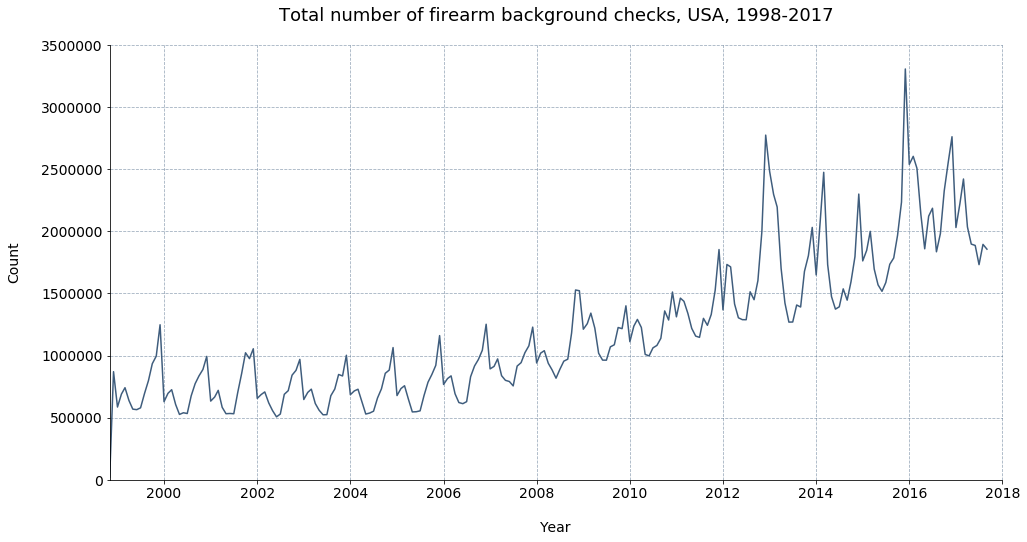

In [25]:
# plot total number of firearm background checks over time
plt.figure(figsize=(16, 8))   

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='both', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   

plt.ylim(0, 3500000)    
plt.xlim(datetime.date(1998, 11, 1), datetime.date(2018, 1, 1))

plt.plot(gun_total_year, color="#3F5D7D")

plt.title("Total number of firearm background checks, USA, 1998-2017",
          fontsize=18,
          ha="center",
          pad=24)

plt.xlabel("Year",
           fontsize=14,
           labelpad=20)

plt.ylabel("Count", 
           fontsize=14,
           labelpad=20)

plt.show()

Overall, we can see an increase in the number of firearm background checks over the time. There seems to be also a seasonal trend. I will have a closer look at it in the next plot.

In [26]:
# calculate total number of firearm background checks per month
gun_total_month = gun_total_year.reset_index()
gun_total_month = gun_total_month.groupby(gun_total_month['month'].dt.strftime('%B'))['totals'].sum().reset_index()

# sort by month - SO https://stackoverflow.com/a/48043319
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

gun_total_month['month'] = pd.Categorical(gun_total_month['month'], categories=months, ordered=True)
gun_total_month.sort_values(by='month',ascending=True,inplace=True)
gun_total_month.reset_index(drop=True, inplace=True)
gun_total_month

,month,totals
0,January,22576465
1,February,24368225
2,March,25337866
3,April,21304597
4,May,18898829
5,June,18547973
6,July,18705500
7,August,20845426
8,September,21603207
9,October,22441249


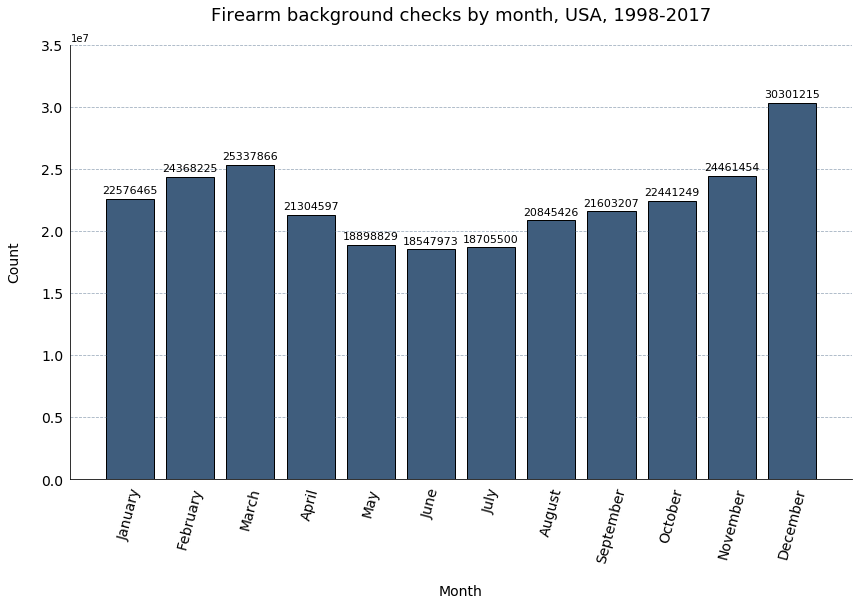

In [27]:
# plot total number of firearm background checks per month
plt.figure(figsize=(14,8)) 

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='y', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.xticks(fontsize=14, rotation=75)
plt.yticks(fontsize=14) 

plt.tick_params(axis="both", which="both", bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True) 

plt.ylim(0, 35000000)    

bar_list = plt.bar(gun_total_month['month'], gun_total_month['totals'], color="#3F5D7D", edgecolor="k")

for a,b in zip(gun_total_month['month'], gun_total_month['totals']):
    plt.text(a, b + 250000, str(b), ha='center', va='bottom', fontsize=11)

plt.title("Firearm background checks by month, USA, 1998-2017",
          fontsize=18,
          ha="center",
          pad=24)

plt.xlabel("Month",
           fontsize=14,
           labelpad=20)

plt.ylabel("Count", 
           fontsize=14,
           labelpad=20)
        
plt.show()

As we can see in the above plot, the number of firearm background checks seems to increase at the end of the year. This might be related to the Black Friday, Christmas and New Years sales, however, we do not have data to prove that suspicion. We can also see a decrease in the number of firearm background checks in the middle of the year - May, June, and July are months with the lowest numbers.

### Which states have had the highest number of firearm background checks per capita?
<hr>

The law on gun purchase can vary significantly between states, which makes it hard to compare states to each other.  Nevertheless, it can be interesting to compare the number of firearm background checks in each state against the state's population.


In [28]:
# calculate total number of firearm background checks per year by state 
gun_total_state = gun[['month','totals','state']]
gun_total_state = gun_total_state.groupby([gun_total_state['state'], gun_total_state['month'].dt.strftime('%Y')])['totals'].sum().reset_index()
gun_total_state.columns = ['state', 'year', 'totals']

# we do not have full year data for 1998 and 2017 in gun dataset
# and population data for 1999 in the census dataset
# we will drop rows for these years
gun_total_state = gun_total_state[(gun_total_state['year'] != '1998') & (gun_total_state['year'] != '1999') & (gun_total_state['year'] != '2017')]
gun_total_state.head()

,state,year,totals
2,Alabama,2000,221911
3,Alabama,2001,230187
4,Alabama,2002,221008
5,Alabama,2003,225479
6,Alabama,2004,229997


In [29]:
# copy population data from the census dataset, we have data for 2010 and 2016 only
population = census[['Population_2010', 'Population_2016']].copy()
population.index.name = 'state'
population.head()

,Population_2010,Population_2016
state,,
Alabama,4779736,4863300
Alaska,710231,741894
Arizona,6392017,6931071
Arkansas,2915918,2988248
California,37253956,39250017


In [30]:
# get gun data for 2010 and 2016
gun_total_state_2010 = gun_total_state[gun_total_state['year'] == '2010'].set_index('state')
gun_total_state_2016 = gun_total_state[gun_total_state['year'] == '2016'].set_index('state')

# merge data into one dataset
gun_total_state_2010_2016 = pd.merge(gun_total_state_2010, gun_total_state_2016, how="left", left_on=gun_total_state_2010.index, right_on=gun_total_state_2016.index, left_index=True).drop(columns=['key_0', 'year_x', 'year_y'])
gun_total_state_2010_2016.columns = ['totals_2010', 'totals_2016']
gun_total_state_2010_2016.head()

,totals_2010,totals_2016
state,,
Alabama,308607,616947
Alaska,65909,87647
Arizona,206050,416279
Arkansas,191448,266014
California,816399,2377167


In [31]:
# check if indexes in population and gun datasets are the same 
gun_total_state_2010_2016.index.isin(population.index)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [32]:
# merge population and gun datasets
growth_data_pop = pd.merge(gun_total_state_2010_2016, population, how="left", left_on=gun_total_state_2010_2016.index, right_on=population.index, left_index=True).drop(columns=['key_0'])
growth_data_pop.head()

,totals_2010,totals_2016,Population_2010,Population_2016
state,,,,
Alabama,308607,616947,4779736,4863300
Alaska,65909,87647,710231,741894
Arizona,206050,416279,6392017,6931071
Arkansas,191448,266014,2915918,2988248
California,816399,2377167,37253956,39250017


In [33]:
# calculate number of firearm background checks per capita for 2010 and 2016
growth_data_pop['checks_per_capita_2010'] = growth_data_pop['totals_2010'] / growth_data_pop['Population_2010']
growth_data_pop['checks_per_capita_2016'] = growth_data_pop['totals_2016'] / growth_data_pop['Population_2016']
growth_data_pop.head()

,totals_2010,totals_2016,Population_2010,Population_2016,checks_per_capita_2010,checks_per_capita_2016
state,,,,,,
Alabama,308607,616947,4779736,4863300,0.064566,0.126858
Alaska,65909,87647,710231,741894,0.092799,0.118140
Arizona,206050,416279,6392017,6931071,0.032236,0.060060
Arkansas,191448,266014,2915918,2988248,0.065656,0.089020
California,816399,2377167,37253956,39250017,0.021914,0.060565


#### Top 10 states with the highest number of firearm background checks per capita for 2010

In [34]:
# sort dataset by number of firearm background checks per capita for 2010
checks_per_capita_2010 = growth_data_pop.sort_values(by='checks_per_capita_2010', ascending=False).reset_index(drop=False)
top10_checks_per_capita_2010 = checks_per_capita_2010[['state','totals_2010', 'Population_2010', 'checks_per_capita_2010']].head(10)
top10_checks_per_capita_2010

,state,totals_2010,Population_2010,checks_per_capita_2010
0,Kentucky,2385579,4339367,0.549753
1,Utah,553134,2763885,0.200129
2,Montana,101095,989415,0.102177
3,Alaska,65909,710231,0.092799
4,West Virginia,159550,1852994,0.086104
5,Wyoming,47709,563626,0.084647
6,South Dakota,63151,814180,0.077564
7,North Dakota,47083,672591,0.070002
8,Arkansas,191448,2915918,0.065656
9,Tennessee,411024,6346105,0.064768


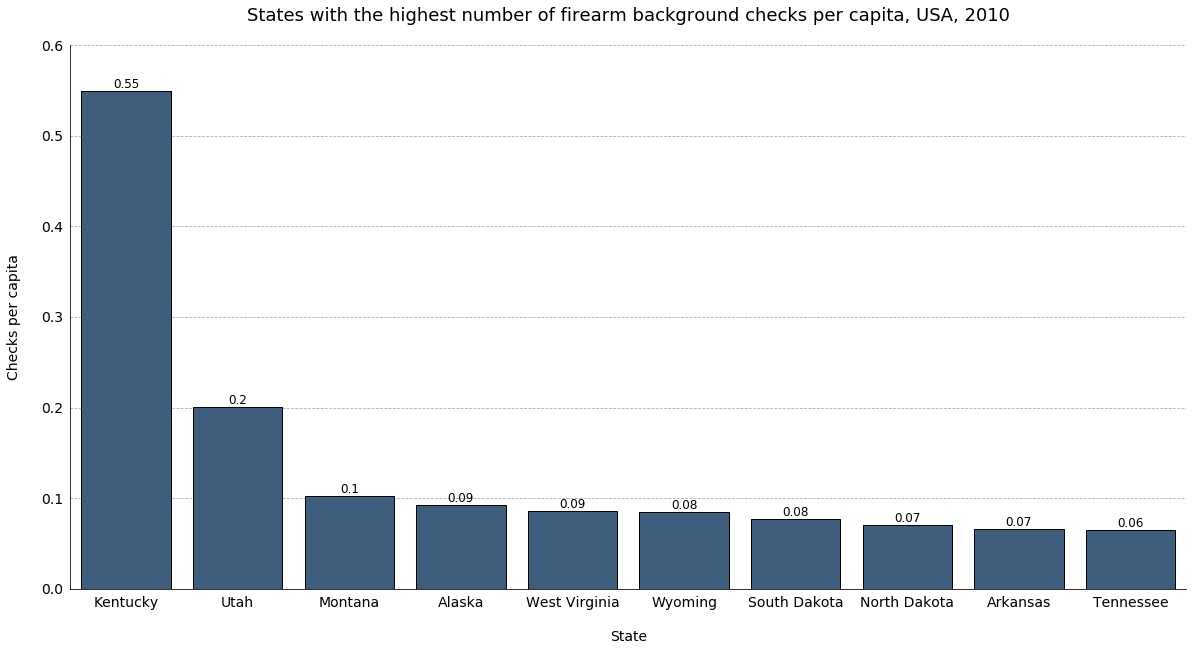

In [35]:
# plot top 10 states with the highest number of firearm background checks per capita in 2010
plt.figure(figsize=(20,10)) 

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='y', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 

plt.tick_params(axis="both", which="both", bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True) 

plt.ylim(0, 0.6)    
plt.xlim(-0.5, 9.5)  

bar_list = plt.bar(top10_checks_per_capita_2010['state'], top10_checks_per_capita_2010['checks_per_capita_2010'], color="#3F5D7D", edgecolor="k")

for a,b in zip(top10_checks_per_capita_2010['state'], top10_checks_per_capita_2010['checks_per_capita_2010']):
    plt.text(a, b, str(round(b,2)), ha='center', va='bottom', fontsize=12)

plt.title("States with the highest number of firearm background checks per capita, USA, 2010",
          fontsize=18,
          ha="center",
          pad=24)

plt.xlabel("State",
           fontsize=14,
           labelpad=20)

plt.ylabel("Checks per capita", 
           fontsize=14,
           labelpad=20)
        
plt.show()

As we can see, Kentucky has a significantly higher number of checks per capita. We do not have enough data to investigate the reason for this difference. It may be caused by legal conditions - more strict control of the sale of weapons, or/and by the higher popularity of gun ownership in this state. However, these are only assumptions that we can not confirm in any way.

#### Top 10 states with the highest number of firearm background checks per capita for 2016

In [36]:
# sort dataset by number of firearm background checks per capita for 2016
checks_per_capita_2016= growth_data_pop.sort_values(by='checks_per_capita_2016', ascending=False).reset_index(drop=False)
top10_checks_per_capita_2016 = checks_per_capita_2016[['state','totals_2016', 'Population_2016', 'checks_per_capita_2016']].head(10)
top10_checks_per_capita_2016

,state,totals_2016,Population_2016,checks_per_capita_2016
0,Kentucky,3676847,4436974,0.828683
1,Indiana,1436725,6633053,0.216601
2,Illinois,1924070,12801539,0.150300
3,West Virginia,242350,1831102,0.132352
4,Montana,136337,1042520,0.130776
5,South Dakota,111921,865454,0.129321
6,Alabama,616947,4863300,0.126858
7,New Hampshire,165164,1334795,0.123737
8,Alaska,87647,741894,0.118140
9,Minnesota,651599,5519952,0.118044


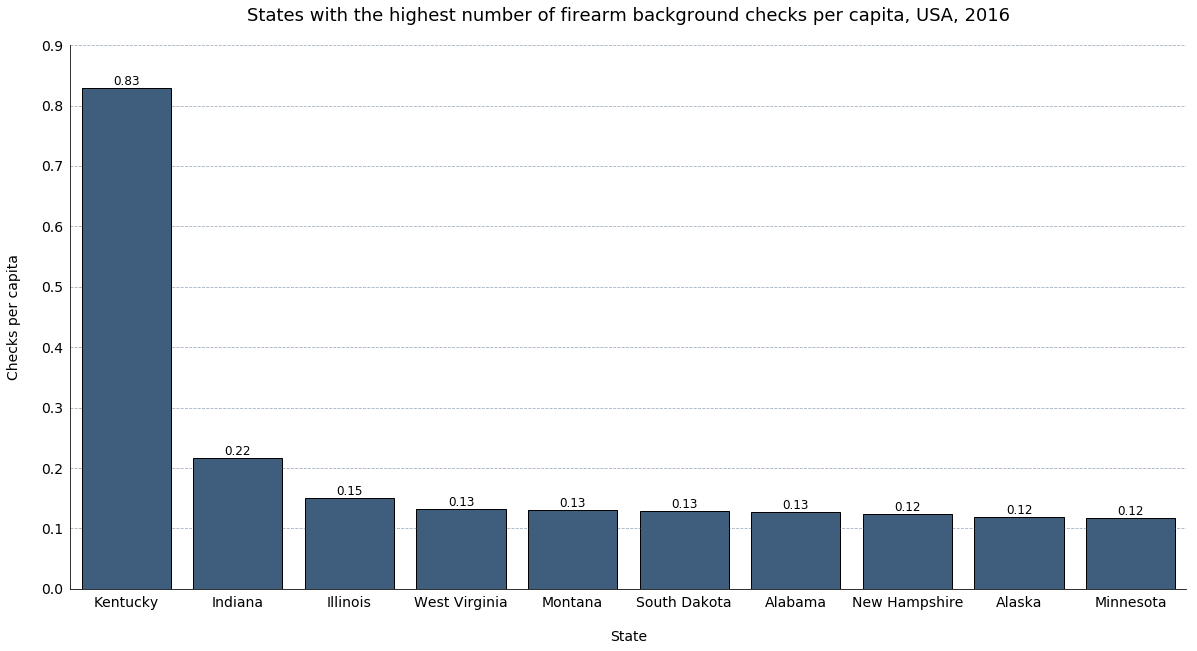

In [37]:
# plot top 10 states with the highest number of firearm background checks per capita in 2016
plt.figure(figsize=(20,10)) 

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='y', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 

plt.tick_params(axis="both", which="both", bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True) 

plt.ylim(0, 0.9)    
plt.xlim(-0.5, 9.5)  

bar_list = plt.bar(top10_checks_per_capita_2016['state'], top10_checks_per_capita_2016['checks_per_capita_2016'], color="#3F5D7D", edgecolor="k")

for a,b in zip(top10_checks_per_capita_2016['state'], top10_checks_per_capita_2016['checks_per_capita_2016']):
    plt.text(a, b, str(round(b,2)), ha='center', va='bottom', fontsize=12)

plt.title("States with the highest number of firearm background checks per capita, USA, 2016",
          fontsize=18,
          ha="center",
          pad=24)

plt.xlabel("State",
           fontsize=14,
           labelpad=20)

plt.ylabel("Checks per capita", 
           fontsize=14,
           labelpad=20)
        
plt.show()

The situation is quite similar for 2016. Again, we can see Kentucky state in the first place, with a significantly higher number of checks per capita than other states. As mentioned already, we do not have enough data to investigate the reason for this difference.

Interestingly, we can see an increase in the number of checks per capita for other states. In 2010, values for most of the states in the top 10 (except for Kentucky) were between `0.2 - 0.06`, while in 2016 values for most of the states (again, excluding Kentucky) are between `10.2 - 0.12`. This increase in the number of checks will become more visible in the further part of the analysis.

### Which states have had the highest growth in gun registrations?
<hr>

#### Percentage increase by state

In [38]:
# for each state, take the total number of firearm background checks form 2000 and 2017
# calculate increase percentage and save to the dataframe and print out

growth = []

for state in gun_total_state['state'].unique():
    first_year = gun_total_state[(gun_total_state['state'] == state) & (gun_total_state['year'] == '2000')]['totals'].iloc[0]
    last_year = gun_total_state[(gun_total_state['state'] == state) & (gun_total_state['year'] == '2016')]['totals'].iloc[0]
    nom_change = last_year - first_year
    per_change = int(round((last_year/first_year) * 100))
    
    result = pd.DataFrame({
        "state": state,
        "first_year": first_year, 
        "last_year": last_year,
        "nom_change": nom_change, 
        "per_change": per_change
    }, index=[0])

    growth.append(result)
            
    print('{} - {}% '.format(state, per_change))

Alabama - 278% 
Alaska - 219% 
Arizona - 281% 
Arkansas - 157% 
California - 299% 
Colorado - 176% 
Connecticut - 363% 
Delaware - 387% 
Florida - 540% 
Georgia - 174% 
Hawaii - 252% 
Idaho - 203% 
Illinois - 428% 
Indiana - 788% 
Iowa - 230% 
Kansas - 203% 
Kentucky - 1599% 
Louisiana - 224% 
Maine - 248% 
Maryland - 196% 
Massachusetts - 412% 
Michigan - 193% 
Minnesota - 352% 
Mississippi - 168% 
Missouri - 330% 
Montana - 192% 
Nebraska - 198% 
Nevada - 297% 
New Hampshire - 412% 
New Jersey - 328% 
New Mexico - 192% 
New York - 247% 
North Carolina - 207% 
North Dakota - 223% 
Ohio - 319% 
Oklahoma - 232% 
Oregon - 240% 
Pennsylvania - 238% 
Rhode Island - 295% 
South Carolina - 313% 
South Dakota - 305% 
Tennessee - 305% 
Texas - 260% 
Utah - 437% 
Vermont - 194% 
Virginia - 280% 
Washington - 532% 
West Virginia - 189% 
Wisconsin - 311% 
Wyoming - 185% 


In [39]:
# concatenate all dataframes to receive final dataframe with results for all states
growth_data = pd.concat(growth, axis=0, ignore_index=True)
growth_data.columns = ['state', 'totals_2000', 'totals_2016', 'nom_change', 'per_change']
growth_data.set_index('state', inplace=True)
growth_data.head()

,totals_2000,totals_2016,nom_change,per_change
state,,,,
Alabama,221911,616947,395036,278
Alaska,39959,87647,47688,219
Arizona,148263,416279,268016,281
Arkansas,169628,266014,96386,157
California,794506,2377167,1582661,299


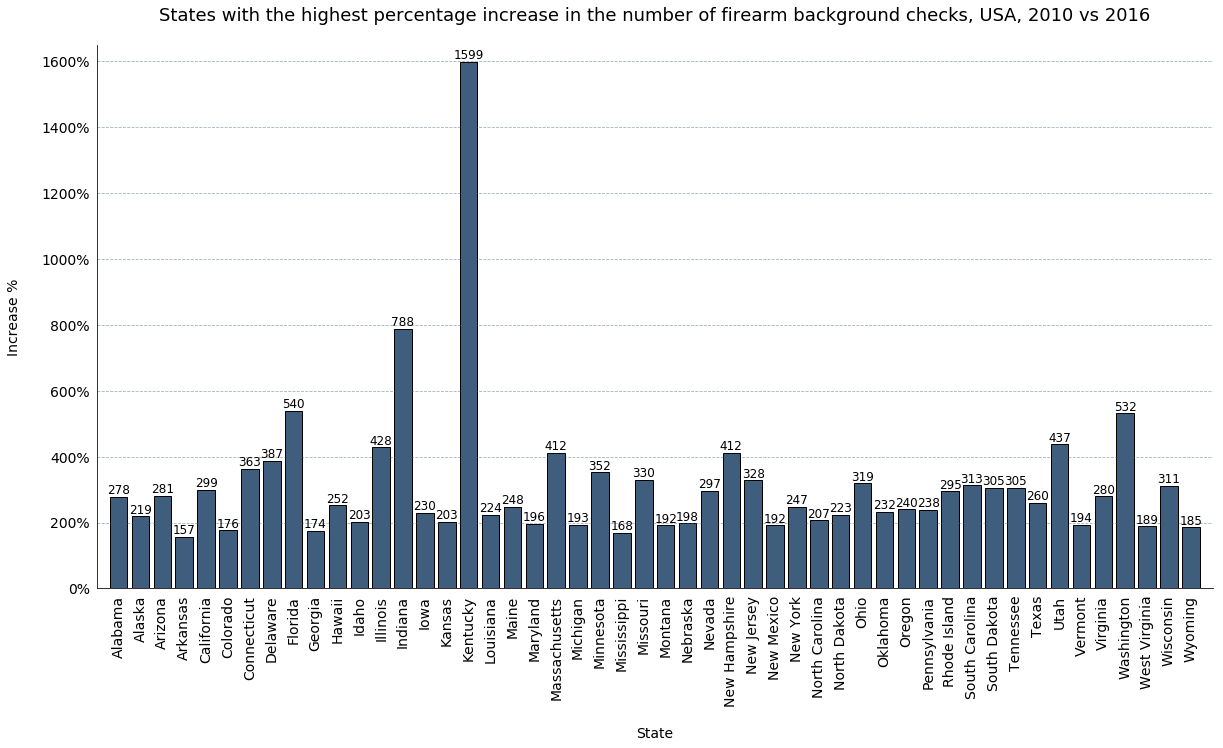

In [40]:
# plot percentage increase by state
plt.figure(figsize=(20,10)) 

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='y', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.xticks(fontsize=14, rotation=90)
plt.yticks(range(0, 1601, 200), [str(x) + "%" for x in range(0, 1601, 200)], fontsize=14) 

plt.tick_params(axis="both", which="both", bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True) 

plt.ylim(0, 1650)    
plt.xlim(-1, 50)  

bar_list = plt.bar(growth_data.index, growth_data['per_change'], color="#3F5D7D", edgecolor="k")

for a,b in zip(growth_data.index, growth_data['per_change']):
    plt.text(a, b, str(round(b,2)), ha='center', va='bottom', fontsize=12)

plt.title("States with the highest percentage increase in the number of firearm background checks, USA, 2010 vs 2016",
          fontsize=18,
          ha="center",
          pad=24)

plt.xlabel("State",
           fontsize=14,
           labelpad=20)

plt.ylabel("Increase %", 
           fontsize=14,
           labelpad=20)
        
plt.show()

In the above plot, we can see a percentage increase in the number of firearm background checks by state. The comparison is made between the number of background checks in 2010 and 2016.

As we can see, the number of checks has significantly increased for all states. This might be related to the increasing popularity of gun possession or/and more strict control of the sale of weapons. Unfortunately, we do not have enough data to investigate the reason for these increases.

#### Top 10 states with the highest percentage increase

In [41]:
# sort dataset by percentage change
growth_data_per = growth_data.sort_values(by='per_change', ascending=False).reset_index(drop=False)
top10_growth_data_per = growth_data_per.head(10)
top10_growth_data_per

,state,totals_2000,totals_2016,nom_change,per_change
0,Kentucky,229896,3676847,3446951,1599
1,Indiana,182319,1436725,1254406,788
2,Florida,266035,1435340,1169305,540
3,Washington,134255,713996,579741,532
4,Utah,67420,294907,227487,437
5,Illinois,449771,1924070,1474299,428
6,Massachusetts,54843,226212,171369,412
7,New Hampshire,40120,165164,125044,412
8,Delaware,15347,59430,44083,387
9,Connecticut,87586,317692,230106,363


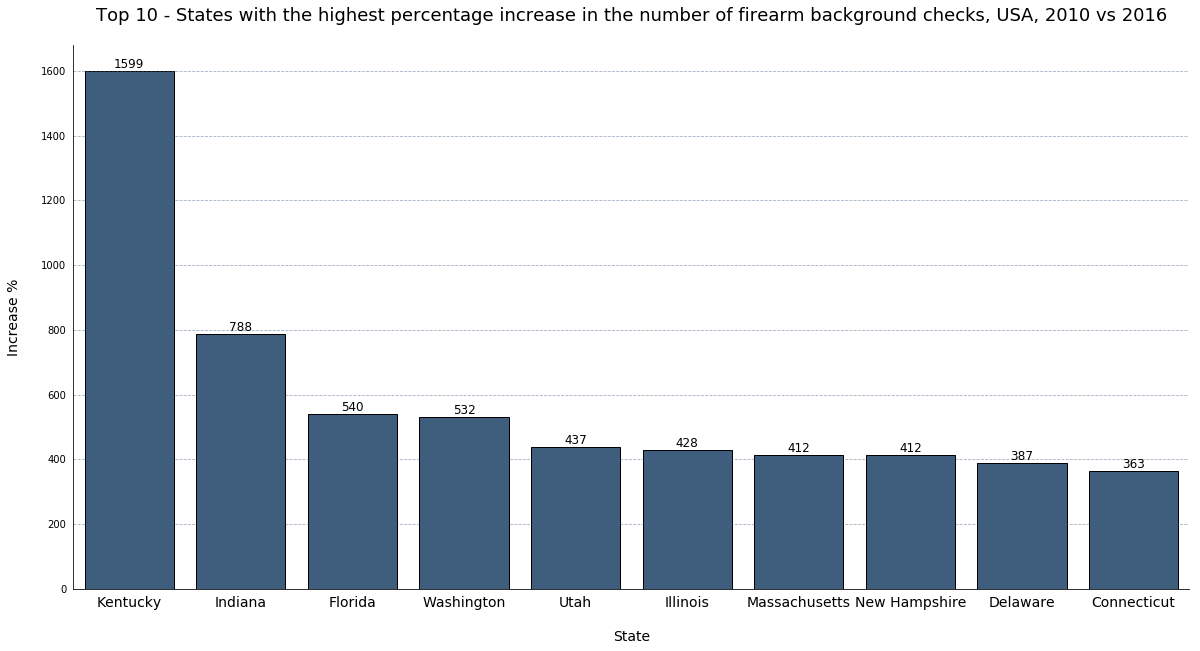

In [42]:
# plot top 10 states with percentage increase
plt.figure(figsize=(20,10)) 

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='y', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.xticks(fontsize=14)
# plt.yticks(range(0, 1601, 200), [str(x) + "%" for x in range(0, 1601, 200)], fontsize=14) 

plt.tick_params(axis="both", which="both", bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True) 

# plt.ylim(0, 1650)    
plt.xlim(-0.5, 9.5)  

bar_list = plt.bar(top10_growth_data_per['state'], top10_growth_data_per['per_change'], color="#3F5D7D", edgecolor="k")

for a,b in zip(top10_growth_data_per['state'], top10_growth_data_per['per_change']):
    plt.text(a, b, str(round(b,2)), ha='center', va='bottom', fontsize=12)

plt.title("Top 10 - States with the highest percentage increase in the number of firearm background checks, USA, 2010 vs 2016",
          fontsize=18,
          ha="center",
          pad=24)

plt.xlabel("State",
           fontsize=14,
           labelpad=20)

plt.ylabel("Increase %", 
           fontsize=14,
           labelpad=20)
        
plt.show()

This is a bit closer look at the statistics for the top 10 states in terms of the percentage increase in the number of firearm background checks. Again, the comparison is made between the number of background checks in 2010 and 2016. We can observe a significant increase in Kentucky, which would require further analysis, as well as in the other states.

#### Top 10 states with the highest nominal increase

In [43]:
# sort dataset by nominal change
growth_data_nom = growth_data.sort_values(by='nom_change', ascending=False).reset_index(drop=False)
top10_growth_data_nom = growth_data_nom.head(10)
top10_growth_data_nom

,state,totals_2000,totals_2016,nom_change,per_change
0,Kentucky,229896,3676847,3446951,1599
1,California,794506,2377167,1582661,299
2,Illinois,449771,1924070,1474299,428
3,Indiana,182319,1436725,1254406,788
4,Florida,266035,1435340,1169305,540
5,Texas,662970,1721726,1058756,260
6,Pennsylvania,481294,1143220,661926,238
7,Ohio,274165,875724,601559,319
8,Washington,134255,713996,579741,532
9,Tennessee,234673,714774,480101,305


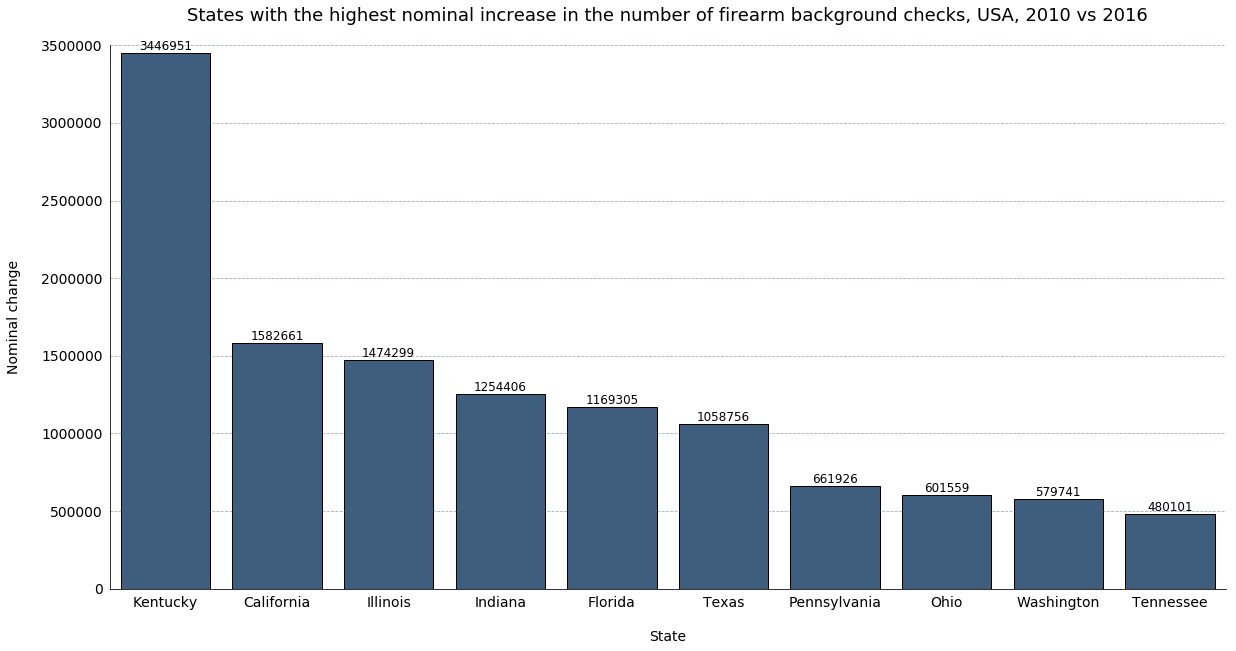

In [44]:
# plot top 10 states with the highest nominal increase
plt.figure(figsize=(20,10)) 

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='y', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 

plt.tick_params(axis="both", which="both", bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True) 

plt.xlim(-0.5, 9.5)    
plt.ylim(0, 3500000)  

bar_list = plt.bar(top10_growth_data_nom['state'], top10_growth_data_nom['nom_change'], color="#3F5D7D", edgecolor="k")

for a,b in zip(top10_growth_data_nom['state'], top10_growth_data_nom['nom_change']):
    plt.text(a, b, str(round(b,2)), ha='center', va='bottom', fontsize=12)

plt.title("States with the highest nominal increase in the number of firearm background checks, USA, 2010 vs 2016",
          fontsize=18,
          ha="center",
          pad=24)

plt.xlabel("State",
           fontsize=14,
           labelpad=20)

plt.ylabel("Nominal change", 
           fontsize=14,
           labelpad=20)
        
plt.show()

In the above plot, we can see a nominal increase in the number of firearm background checks by state. The comparison is made between the number of background checks in 2010 and 2016.

As we can see, the number of checks has significantly increased for all states. Again, this might be related to the increasing popularity of gun possession or/and more strict control of the sale of weapons. Unfortunately, we do not have enough data to investigate the reason for these increases.

#### What census data is most associated with high gunregistration?

In [45]:
# get checks per capita
gun_checks_capita = growth_data_pop.drop(['Population_2010','Population_2016'], axis=1)
gun_checks_capita.head()

,totals_2010,totals_2016,checks_per_capita_2010,checks_per_capita_2016
state,,,,
Alabama,308607,616947,0.064566,0.126858
Alaska,65909,87647,0.092799,0.118140
Arizona,206050,416279,0.032236,0.060060
Arkansas,191448,266014,0.065656,0.089020
California,816399,2377167,0.021914,0.060565


In [46]:
# merge census dateset with checks per capita from the gun dataset
census_gun = pd.merge(census, 
                      gun_checks_capita, 
                      how="left", 
                      left_on=census.index, 
                      right_on=gun_checks_capita.index, 
                      left_index=True
                     ).drop(columns=['key_0'])
census_gun.head()

,Population_2010,Population_2016,Population_sq_mile_2010,Land_area_sq_mile_2010,White_2016,Hispanic_Latino_2016,Black_African_American_2016,American_Indian_Alaska_Native_2016,Native_Hawaiian_Pacific_Islander_2016,Asian_2016,...,With_disability_2011-2015,Persons_in_poverty,Persons_no_health_insurance,Persons_per_household_2011-2015,Per_capita_income_past_12_months_2011-2015,Median_household_income_2011-2015,totals_2010,totals_2016,checks_per_capita_2010,checks_per_capita_2016
state,,,,,,,,,,,,,,,,,,,,,
Alabama,4779736,4863300,94.4,50645.33,0.658,0.042,0.268,0.007,0.001,0.014,...,0.118,0.171,0.107,0.0255,24091,43623,308607,616947,0.064566,0.126858
Alaska,710231,741894,1.2,570640.95,0.612,0.070,0.038,0.152,0.013,0.063,...,0.081,0.099,0.155,0.0281,33413,72515,65909,87647,0.092799,0.118140
Arizona,6392017,6931071,56.3,113594.08,0.555,0.309,0.049,0.054,0.003,0.034,...,0.082,0.164,0.119,0.0269,25848,50255,206050,416279,0.032236,0.060060
Arkansas,2915918,2988248,56.0,52035.48,0.729,0.073,0.157,0.010,0.003,0.016,...,0.123,0.172,0.093,0.0253,22798,41371,191448,266014,0.065656,0.089020
California,37253956,39250017,239.1,155779.22,0.377,0.389,0.065,0.017,0.005,0.148,...,0.068,0.143,0.083,0.0296,30318,61818,816399,2377167,0.021914,0.060565


In [47]:
# compute the Pearson correlation coefficient
census_gun.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,Population_2010,Population_2016,Population_sq_mile_2010,Land_area_sq_mile_2010,White_2016,Hispanic_Latino_2016,Black_African_American_2016,American_Indian_Alaska_Native_2016,Native_Hawaiian_Pacific_Islander_2016,Asian_2016,Foreign_born_persons_2011-2015,Language_not_English_spoken_home_2011-2015,High_school_or_higher_2011-2015,Bachelor_or_higher_2011-2015,Veterans_2011-2015,With_disability_2011-2015,Persons_in_poverty,Persons_no_health_insurance,Persons_per_household_2011-2015,Per_capita_income_past_12_months_2011-2015,Median_household_income_2011-2015,totals_2010,totals_2016,checks_per_capita_2010,checks_per_capita_2016
Population_2010,1.0,1.0,0.17,0.13,-0.22,0.56,0.11,-0.12,-0.099,0.16,0.48,0.51,-0.052,0.014,0.96,-0.11,0.055,0.12,0.37,0.091,0.064,0.43,0.61,-0.16,-0.1
Population_2016,1.0,1.0,0.16,0.14,-0.22,0.57,0.11,-0.12,-0.096,0.16,0.49,0.53,-0.045,0.021,0.96,-0.1,0.062,0.14,0.38,0.084,0.061,0.43,0.61,-0.16,-0.1
Population_sq_mile_2010,0.17,0.16,1.0,-0.35,-0.15,0.1,0.17,-0.22,-0.024,0.17,0.34,0.26,-0.053,0.11,0.12,-0.17,-0.16,-0.2,0.082,0.6,0.5,-0.09,-0.045,-0.24,-0.2
Land_area_sq_mile_2010,0.13,0.14,-0.35,1.0,0.0042,0.26,-0.13,0.85,0.01,0.021,0.098,0.22,0.091,0.038,0.12,0.026,0.065,0.4,0.31,-0.011,0.13,0.051,0.053,0.067,0.0078
White_2016,-0.22,-0.22,-0.15,0.0042,1.0,0.22,0.26,0.23,-0.093,0.036,0.26,0.27,0.91,0.83,-0.22,0.89,0.79,0.63,-0.095,0.046,0.088,0.046,0.024,0.22,0.22
Hispanic_Latino_2016,0.56,0.57,0.1,0.26,0.22,1.0,0.19,0.18,0.093,0.4,0.86,0.93,0.48,0.52,0.54,0.29,0.45,0.6,0.57,0.17,0.28,0.2,0.31,-0.13,-0.15
Black_African_American_2016,0.11,0.11,0.17,-0.13,0.26,0.19,1.0,-0.094,-0.094,0.075,0.31,0.26,0.43,0.39,0.15,0.5,0.61,0.52,0.19,-0.036,-0.036,0.062,0.092,-0.08,-0.029
American_Indian_Alaska_Native_2016,-0.12,-0.12,-0.22,0.85,0.23,0.18,-0.094,1.0,0.077,0.079,0.12,0.2,0.29,0.24,-0.14,0.2,0.19,0.43,0.22,0.1,0.24,-0.12,-0.13,0.07,0.0075
Native_Hawaiian_Pacific_Islander_2016,-0.099,-0.096,-0.024,0.01,-0.093,0.093,-0.094,0.077,1.0,0.88,0.29,0.27,0.15,0.15,-0.11,0.03,0.024,-0.0046,0.48,0.06,0.3,-0.1,-0.11,-0.071,-0.11
Asian_2016,0.16,0.16,0.17,0.021,0.036,0.4,0.075,0.079,0.88,1.0,0.66,0.61,0.35,0.41,0.11,0.16,0.18,0.14,0.58,0.3,0.52,-0.044,0.022,-0.17,-0.17


We can see that the strongest correlation is between the checks per capita, household income and the number of veterans. For other columns, correlation is low or negative. Therefore, I will plot the number of checks per capita with household income and the number of veterans.

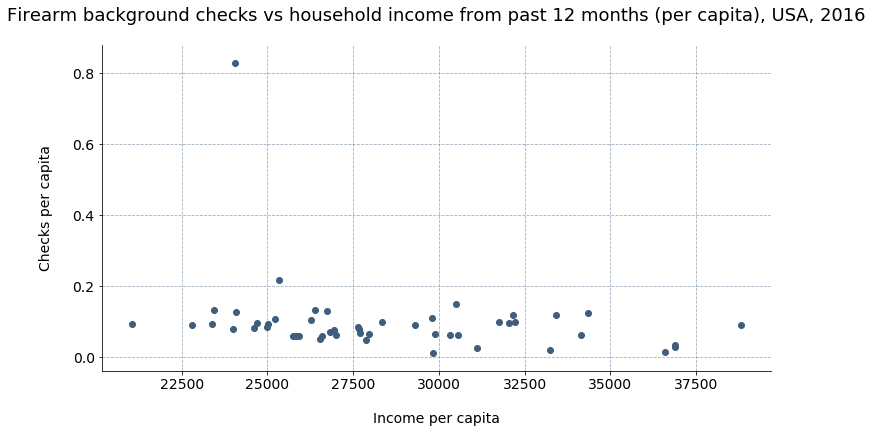

In [48]:
# plot firearm background checks in 2016 vs household income (2011-2015) from past 12 months (per capita)
plt.figure(figsize=(12, 6))   

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='both', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   

plt.scatter(census_gun['Per_capita_income_past_12_months_2011-2015'],
            census_gun['checks_per_capita_2016'], 
            color="#3F5D7D")
    
plt.title("Firearm background checks vs household income from past 12 months (per capita), USA, 2016",
          fontsize=18,
          ha="center",
          pad=24)

plt.xlabel("Income per capita",
           fontsize=14,
           labelpad=20)

plt.ylabel("Checks per capita", 
           fontsize=14,
           labelpad=20)

plt.show()

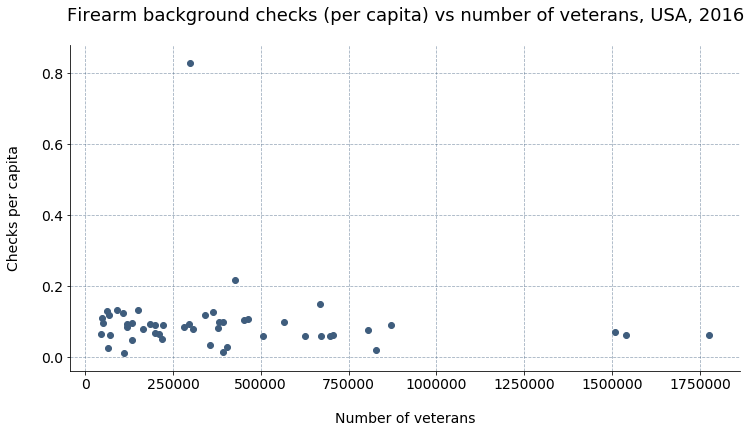

In [49]:
# plot firearm background checks in 2016 (per capita) vs number of veterans (2011-2015)
plt.figure(figsize=(12, 6))   

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='both', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   

plt.scatter(census_gun['Veterans_2011-2015'],
            census_gun['checks_per_capita_2016'], 
            color="#3F5D7D")
    
plt.title("Firearm background checks (per capita) vs number of veterans, USA, 2016",
          fontsize=18,
          ha="center",
          pad=24)

plt.xlabel("Number of veterans",
           fontsize=14,
           labelpad=20)

plt.ylabel("Checks per capita", 
           fontsize=14,
           labelpad=20)

plt.show()

<a id='conclusions'></a>
## Conclusions

In general, we can see that the number of firearm background checks is increasing over time. This increase has been significant over the past 19 years. Further analysis is required to determine the reasons for such a high increase. 

Correlation between the number of checks and census data is rather low. Household income and the number of veterans show the highest correlation among all data points but are still rather low. 

These datasets have a lot of limitations, which constrain the analysis. Census dataset does not contain information for all the years, and in many cases, provided values represent multiple years. 

A further analysis is required. 